In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.metrics import precision_recall_fscore_support

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 40
batch_size = 64
learning_rate = 0.001
num_classes = 10

# Transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize RGB channels
])

# Load the dataset
train_dataset = torchvision.datasets.ImageFolder(root='Sign-Language-Digits-Dataset/train', transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root='Sign-Language-Digits-Dataset/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define your model architecture
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)  # Flatten the tensor
        out = F.relu(self.fc1(out))
        out = self.dropout(out) 
        out = self.fc2(out)
        return out

# Function to train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')

# Function to test the model
def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
             # Collect all labels and predictions for F1 score calculation
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        print(f'Accuracy of the model on the test images: {100 * correct / total} %')
        # Calculate precision, recall, and F1 score
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_predictions, average='weighted'
        )
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')
# Instantiate the model
model_cnn = CNN(num_classes=num_classes).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=learning_rate)
print("Training CNN model")
train_model(model_cnn, train_loader, criterion, optimizer_cnn, num_epochs)
print("Testing CNN model")
test_model(model_cnn, test_loader)

Training CNN model
Testing CNN model
Accuracy of the model on the test images: 94.0 %
Precision: 0.9433
Recall: 0.9400
F1 Score: 0.9398


In [12]:
import torch
torch.save(model_cnn.state_dict(), 'model_cnn.pth')

In [5]:
# Instantiate the model
model_cnn = CNN(num_classes=10).to(device)

# Load the state dictionary
model_cnn.load_state_dict(torch.load('model_cnn.pth'))
test_model(model_cnn, test_loader)
# Set the model to evaluation mode if you're going to use it for inference
#model_cnn.eval()

C:\Users\HP\AppData\Local\Temp\ipykernel_892\3016606729.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_cnn.load_state_dict(torch.load('model_cnn.pth'))


Accuracy of the model on the test images: 90.0 %
Precision: 0.9181
Recall: 0.9000
F1 Score: 0.8979


Predicted class: 3


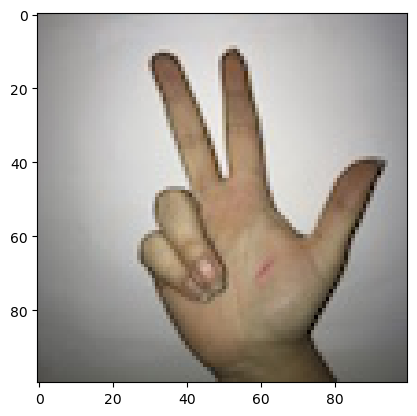

In [23]:
from PIL import Image
import matplotlib.pyplot as plt

# Function to predict the class of a single image
def predict_single_image(model, image_path, device):
    # Define the transformations (same as used in training)
    transform = transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Same normalization as during training
    ])

    # Load the image
    image = Image.open(image_path)
    plt.imshow(image)

    # Apply transformations
    image = transform(image)
    

    # Add a batch dimension
    image = image.unsqueeze(0)

    # Move the image tensor to the device
    image = image.to(device)
   

    # Set model to evaluation mode
    model.eval()

    # Make the prediction
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output.data, 1)

    # Return the predicted class index
    return predicted.item()

# Example usage
# Assume model_cnn or model_fc is the trained model and 'image_path' is the path to your image
# model_cnn = CNN(num_classes=10).to(device)
# model_cnn.load_state_dict(torch.load('model_cnn.pth'))
image_path = 'Sign-Language-Digits-Dataset/valid/A3/IMG_5490.JPG'  # Replace with your image path
predicted_class = predict_single_image(model_cnn, image_path, device)
print(f'Predicted class: {predicted_class}')

In [23]:
!pip install rembg

                                              0.5/38.8 MB 6.1 kB/s eta 1:45:04


ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 435, in _error_catcher
    yield
  File "C:\Users\HP\anaconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 516, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "C:\Users\HP\anaconda3\lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 90, in read
    data = self.__fp.read(amt)
  File "C:\Users\HP\anaconda3\lib\http\client.py", line 463, in read
    n = self.readinto(b)
  File "C:\Users\HP\anaconda3\lib\http\client.py", line 507, in readinto
    n = self.fp.readinto(b)
  File "C:\Users\HP\anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Users\HP\anaconda3\lib\ssl.py", line 1242, in recv_into
    return self.read(nbytes, buffer)
  File "C:\Users\HP\anaconda3\lib\ssl.py", line 1100, in read
    return self._sslobj.read(len, buffer)
socket.timeout: The read op

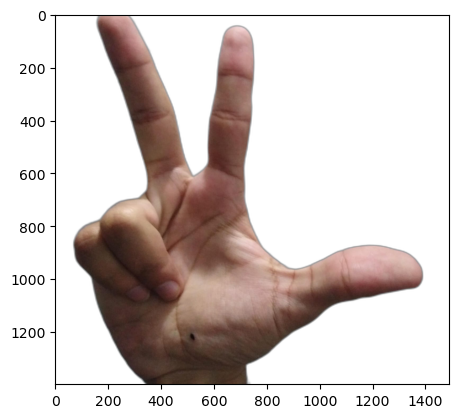

In [12]:
from rembg import remove
from PIL import Image
import matplotlib.pyplot as plt

# Load the input image
input_path = 'teen.jpeg'

def removebg(input_path):
    # Open the image file
    with Image.open(input_path) as input_image:
        # Remove the background
        output_image = remove(input_image)

        # Save the output image with a transparent background
        return output_image
output=convert_image_to_jpg(input_path)
output=removebg(input_path)
plt.imshow(output)


In [3]:
from PIL import Image
import os
import io

def convert_image_to_jpg(image_path, quality=95):
    # Open the image using PIL
    with Image.open(image_path) as img:
        # Convert the image to RGB if it is in a different mode
        if img.mode in ("RGBA", "P"):
            img = img.convert("RGB")
        
        # Save the image to a BytesIO object in JPEG format
        with io.BytesIO() as img_bytes:
            img.save(img_bytes, format='JPEG', quality=quality)
            img_bytes.seek(0)
            
            # Open the image from the BytesIO object to check its format
            jpg_image = Image.open(img_bytes)
            # Verify the format is JPEG
            assert jpg_image.format == 'JPEG', "Image conversion to JPEG failed."

            # For further processing, you may return the in-memory image or bytes
            return jpg_image

# Example usage
jpg_image = convert_image_to_jpg('car.png')

# Print the format to confirm
print(f"Converted image format: {jpg_image.format}")


Converted image format: JPEG


### Prediction

Predicted class: 3


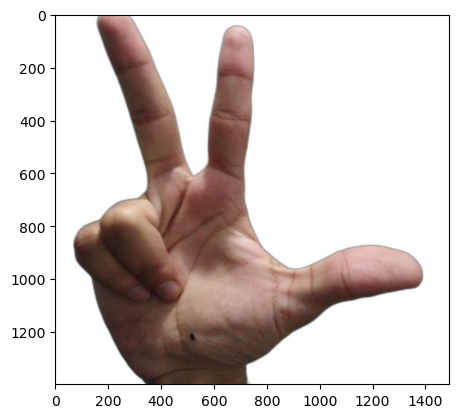

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from rembg import remove
from PIL import Image
import matplotlib.pyplot as plt
import os
import io
def convert_image_to_jpg(image, quality=95, background_color=(255, 255, 255)):
      # Convert the image to RGB if it is in a different mode or has transparency
    if image.mode in ("RGBA", "P"):
        background = Image.new("RGB", image.size, background_color)
        background.paste(image, mask=image.split()[3])  # 3 is the alpha channel
        image = background
    
    # Save the image to a BytesIO object in JPEG format
    img_bytes = io.BytesIO()
    image.save(img_bytes, format='JPEG', quality=quality)
    img_bytes.seek(0)
    
    # Open the image from the BytesIO object to check its format
    jpg_image = Image.open(img_bytes)
    # Verify the format is JPEG
    assert jpg_image.format == 'JPEG', "Image conversion to JPEG failed."

    # For further processing, you may return the in-memory image or bytes
    return jpg_image
def removebg(input_path):
    # Open the image file
    with Image.open(input_path) as input_image:
        # Remove the background
        output_image = remove(input_image)

        # Save the output image with a transparent background
        return output_image
    
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(32 * 25 * 25, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # Flatten the tensor
        out = F.relu(self.fc1(out))
        out = self.dropout(out) 
        out = self.fc2(out)
        return out

def predict_single_image(model, image, device):
    # Define the transformations (same as used in training)
    transform = transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Same normalization as during training
    ])

    # Load the image
    #image = Image.open(image_path)
    #plt.imshow(image)

    # Apply transformations
    image = transform(image)
    

    # Add a batch dimension
    image = image.unsqueeze(0)

    # Move the image tensor to the device
    image = image.to(device)
   

    # Set model to evaluation mode
    model.eval()

    # Make the prediction
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output.data, 1)

    # Return the predicted class index
    return predicted.item()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#Instantiate the model
# model_cnn = CNN(num_classes=10).to(device)

# # Load the state dictionary
# model_cnn.load_state_dict(torch.load('model_cnn.pth'))
image_path = 'teen.jpeg'  # Replace with your image path
image_path=removebg(image_path)
#plt.imshow(image_path)
image_path=convert_image_to_jpg(image_path)
plt.imshow(image_path)
predicted_class = predict_single_image(model_cnn, image_path, device)
print(f'Predicted class: {predicted_class}')
